# FIKH Model: Stress Relaxation

## Learning Objectives

1. Generate **synthetic relaxation data** from NB01 calibrated parameters
2. Understand **power-law vs exponential decay** controlled by alpha_structure
3. Fit FIKH to relaxation data and infer fractional order
4. Visualize how alpha affects long-time relaxation tails
5. Use Bayesian inference to quantify uncertainty in alpha

## Prerequisites

- **NB01**: FIKH Flow Curve (provides calibrated parameters)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_fikh_parameters,
    generate_synthetic_relaxation,
    save_fikh_results,
    set_model_parameters,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    plot_alpha_sweep,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Fractional Relaxation

Stress relaxation reveals the **memory kernel** most clearly:

### Classical IKH ($\alpha = 1$)
$$
\sigma(t) \sim \sigma_0 \exp(-t/\tau)
$$

### FIKH ($0 < \alpha < 1$)
$$
\sigma(t) \sim \sigma_0 E_\alpha(-(t/\tau)^\alpha)
$$

where $E_\alpha$ is the Mittag-Leffler function with asymptotic behavior:
- **Short times**: $E_\alpha(x) \approx \exp(x)$ (exponential-like)
- **Long times**: $E_\alpha(-x) \sim x^{-1}/\Gamma(1-\alpha)$ (power-law tail)

### Key Observation

The **long-time tail** distinguishes FIKH from IKH:
- $\alpha = 1$: Exponential decay (fast)
- $\alpha < 1$: Power-law decay $\sim t^{-\alpha}$ (slow)

## 3. Load Calibrated Parameters

In [3]:
# Try to load parameters from NB01, fall back to defaults
try:
    calibrated_params = load_fikh_parameters("fikh", "flow_curve")
    print("Loaded calibrated parameters from NB01:")
    for name, val in calibrated_params.items():
        print(f"  {name:15s} = {val:.4g}")
except FileNotFoundError:
    print("NB01 parameters not found. Using defaults.")
    calibrated_params = None

Loaded calibrated parameters from NB01:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


In [4]:
# Create model and set parameters
model = FIKH(include_thermal=False, alpha_structure=0.7)

if calibrated_params is not None:
    set_model_parameters(model, calibrated_params)

param_names = get_fikh_param_names(include_thermal=False)
print(f"\nModel parameters:")
for name in param_names:
    print(f"  {name:15s} = {model.parameters.get_value(name):.4g}")


Model parameters:
  G               = 1000
  eta             = 1.527e+06
  C               = 2.11e+04
  gamma_dyn       = 2.96
  m               = 0.5093
  sigma_y0        = 1.328
  delta_sigma_y   = 0.03586
  tau_thix        = 3.777e+07
  Gamma           = 3125
  alpha_structure = 0.7
  eta_inf         = 0.5119
  mu_p            = 0.001036


## 4. Generate Synthetic Data

In [5]:
# Generate synthetic relaxation data with 3% noise
SIGMA_0 = 100.0  # Initial stress
T_END = 100.0    # End time
NOISE_LEVEL = 0.03

time_data, stress_data = generate_synthetic_relaxation(
    model,
    sigma_0=SIGMA_0,
    t_end=T_END,
    n_points=200,
    noise_level=NOISE_LEVEL,
    seed=42,
)

print(f"Generated synthetic relaxation data:")
print(f"  Initial stress: {SIGMA_0} Pa")
print(f"  Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"  Noise level: {NOISE_LEVEL*100:.0f}%")

Generated synthetic relaxation data:
  Initial stress: 100.0 Pa
  Time range: [0.0100, 100.00] s
  Noise level: 3%


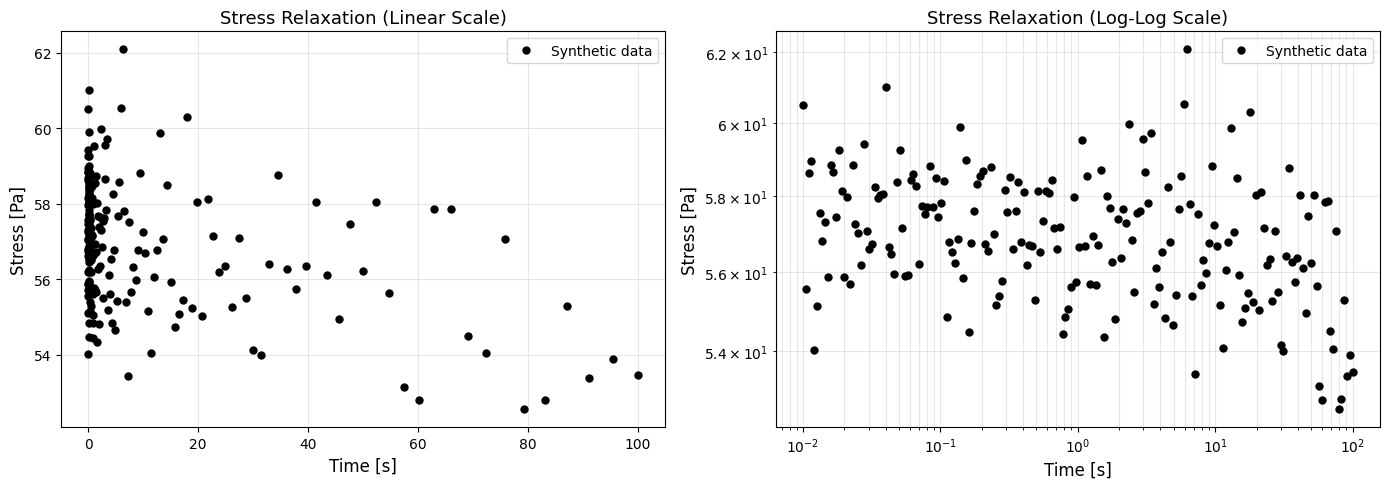

In [6]:
# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Stress Relaxation (Linear Scale)", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Log-log scale (shows power-law tail)
ax2.loglog(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Relaxation (Log-Log Scale)", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Sweep: Power-Law vs Exponential

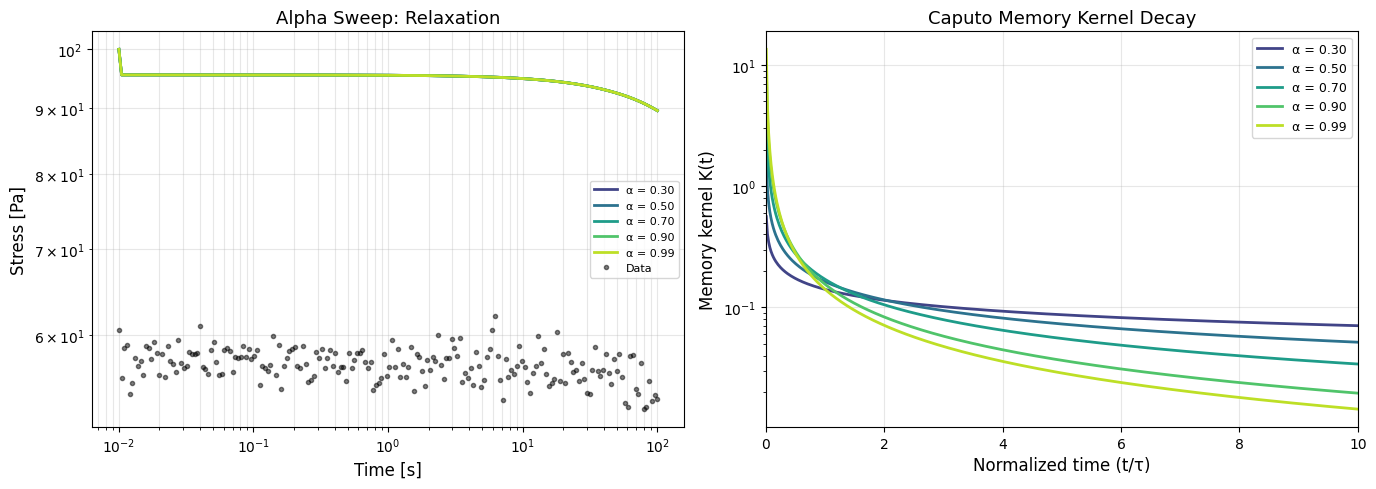

In [7]:
# Show alpha effect on relaxation
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="relaxation",
    alpha_values=alpha_values,
    x_data=time_data,
    sigma_0=SIGMA_0,
    figsize=(14, 5),
)

# Add data to left panel
fig.axes[0].loglog(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

## 6. NLSQ Fitting

In [8]:
# Fit to synthetic data (verify recovery of true parameters)
model_fit = FIKH(include_thermal=False, alpha_structure=0.5)  # Start from different alpha

t0 = time.time()
model_fit.fit(time_data, stress_data, test_mode="relaxation", sigma_0=SIGMA_0, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted vs True parameters:")
for name in param_names:
    fitted = model_fit.parameters.get_value(name)
    true_val = model.parameters.get_value(name)
    rel_err = abs(fitted - true_val) / (abs(true_val) + 1e-10) * 100
    print(f"  {name:15s}: fitted={fitted:.4g}, true={true_val:.4g} (err={rel_err:.1f}%)")

NLSQ fit time: 147.46 s

Fitted vs True parameters:
  G              : fitted=999.9, true=1000 (err=0.0%)
  eta            : fitted=1.17e+06, true=1.527e+06 (err=23.4%)
  C              : fitted=500.5, true=2.11e+04 (err=97.6%)
  gamma_dyn      : fitted=1, true=2.96 (err=66.2%)
  m              : fitted=1, true=0.5093 (err=96.3%)
  sigma_y0       : fitted=0.005089, true=1.328 (err=99.6%)
  delta_sigma_y  : fitted=74.75, true=0.03586 (err=208333.8%)
  tau_thix       : fitted=376.6, true=3.777e+07 (err=100.0%)
  Gamma          : fitted=0.4999, true=3125 (err=100.0%)
  alpha_structure: fitted=0.5, true=0.7 (err=28.6%)
  eta_inf        : fitted=0.1, true=0.5119 (err=80.5%)
  mu_p           : fitted=0.008617, true=0.001036 (err=731.8%)


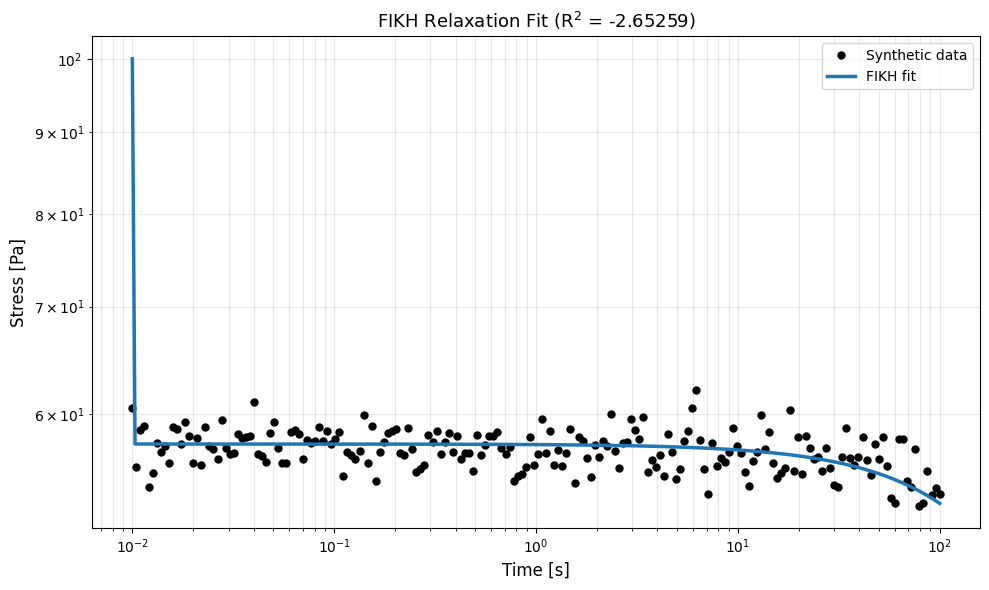

In [9]:
# Plot fit
stress_pred = model_fit.predict_relaxation(time_data, sigma_0=SIGMA_0)
metrics = compute_fit_quality(stress_data, stress_pred)

time_fine = np.logspace(np.log10(time_data.min()), np.log10(time_data.max()), 300)
stress_pred_fine = model_fit.predict_relaxation(time_fine, sigma_0=SIGMA_0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(time_data, stress_data, "ko", markersize=5, label="Synthetic data")
ax.loglog(time_fine, stress_pred_fine, "-", lw=2.5, color="C0", label="FIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"FIKH Relaxation Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [10]:
# Bayesian inference
initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model_fit.fit_bayesian(
    time_data,
    stress_data,
    test_mode="relaxation",
    sigma_0=SIGMA_0,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


/Users/b80985/Projects/rheojax/rheojax/core/base.py:457: RuntimeWarning: Warm-started NUTS initialization failed; retrying with uniform init.
  result = super().fit_bayesian(


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:05<1:03:02,  5.41s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 4/700 [00:05<12:46,  1.10s/it, 1023 steps of size 5.47e-03. acc. prob=0.33]

warmup:   1%|          | 5/700 [00:06<10:11,  1.14it/s, 1023 steps of size 4.06e-03. acc. prob=0.47]

warmup:   1%|          | 6/700 [00:06<08:12,  1.41it/s, 1023 steps of size 3.39e-03. acc. prob=0.56]

warmup:   1%|          | 7/700 [00:06<06:44,  1.71it/s, 1023 steps of size 3.06e-03. acc. prob=0.62]

warmup:   1%|          | 8/700 [00:06<06:12,  1.86it/s, 1023 steps of size 2.92e-03. acc. prob=0.67]

warmup:   1%|▏         | 9/700 [00:07<05:28,  2.10it/s, 1023 steps of size 2.90e-03. acc. prob=0.70]

warmup:   1%|▏         | 10/700 [00:07<05:05,  2.26it/s, 1023 steps of size 2.96e-03. acc. prob=0.73]

warmup:   2%|▏         | 11/700 [00:08<04:42,  2.43it/s, 1023 steps of size 3.08e-03. acc. prob=0.76]

warmup:   2%|▏         | 12/700 [00:08<04:12,  2.72it/s, 1023 steps of size 3.26e-03. acc. prob=0.78]

warmup:   2%|▏         | 13/700 [00:08<04:05,  2.80it/s, 1023 steps of size 3.48e-03. acc. prob=0.79]

warmup:   2%|▏         | 14/700 [00:08<03:56,  2.90it/s, 1023 steps of size 3.75e-03. acc. prob=0.81]

warmup:   2%|▏         | 15/700 [00:09<04:00,  2.85it/s, 1023 steps of size 4.07e-03. acc. prob=0.82]

warmup:   2%|▏         | 16/700 [00:09<03:56,  2.89it/s, 1023 steps of size 4.40e-03. acc. prob=0.83]

warmup:   2%|▏         | 17/700 [00:09<03:42,  3.07it/s, 1023 steps of size 4.78e-03. acc. prob=0.84]

warmup:   3%|▎         | 18/700 [00:10<03:33,  3.19it/s, 1023 steps of size 5.22e-03. acc. prob=0.85]

warmup:   3%|▎         | 19/700 [00:10<04:09,  2.73it/s, 1023 steps of size 5.71e-03. acc. prob=0.86]

warmup:   3%|▎         | 20/700 [00:11<04:03,  2.80it/s, 1023 steps of size 6.25e-03. acc. prob=0.87]

warmup:   3%|▎         | 21/700 [00:11<04:27,  2.54it/s, 1023 steps of size 6.84e-03. acc. prob=0.87]

warmup:   3%|▎         | 22/700 [00:11<04:24,  2.57it/s, 1023 steps of size 7.49e-03. acc. prob=0.88]

warmup:   3%|▎         | 23/700 [00:12<04:00,  2.81it/s, 1023 steps of size 8.13e-03. acc. prob=0.88]

warmup:   3%|▎         | 24/700 [00:12<03:51,  2.93it/s, 1023 steps of size 8.88e-03. acc. prob=0.89]

warmup:   4%|▎         | 25/700 [00:12<03:13,  3.49it/s, 511 steps of size 9.68e-03. acc. prob=0.89] 

warmup:   4%|▎         | 26/700 [00:12<03:10,  3.54it/s, 1023 steps of size 1.06e-02. acc. prob=0.90]

warmup:   4%|▍         | 27/700 [00:13<02:45,  4.08it/s, 511 steps of size 1.15e-02. acc. prob=0.90] 

warmup:   4%|▍         | 28/700 [00:13<02:24,  4.64it/s, 511 steps of size 1.25e-02. acc. prob=0.90]

warmup:   4%|▍         | 29/700 [00:13<02:18,  4.85it/s, 511 steps of size 1.32e-02. acc. prob=0.91]

warmup:   4%|▍         | 30/700 [00:13<02:10,  5.13it/s, 511 steps of size 1.41e-02. acc. prob=0.91]

warmup:   4%|▍         | 31/700 [00:13<01:54,  5.83it/s, 511 steps of size 1.53e-02. acc. prob=0.91]

warmup:   5%|▍         | 32/700 [00:13<01:47,  6.22it/s, 511 steps of size 1.65e-02. acc. prob=0.92]

warmup:   5%|▍         | 33/700 [00:13<01:48,  6.15it/s, 511 steps of size 1.77e-02. acc. prob=0.92]

warmup:   5%|▍         | 34/700 [00:14<01:42,  6.52it/s, 511 steps of size 1.89e-02. acc. prob=0.92]

warmup:   5%|▌         | 36/700 [00:14<01:24,  7.89it/s, 255 steps of size 2.11e-02. acc. prob=0.92]

warmup:   5%|▌         | 37/700 [00:14<01:20,  8.28it/s, 255 steps of size 2.23e-02. acc. prob=0.93]

warmup:   5%|▌         | 38/700 [00:14<01:23,  7.93it/s, 255 steps of size 2.39e-02. acc. prob=0.93]

warmup:   6%|▌         | 39/700 [00:14<01:23,  7.92it/s, 255 steps of size 2.52e-02. acc. prob=0.93]

warmup:   6%|▌         | 41/700 [00:14<01:09,  9.54it/s, 255 steps of size 2.75e-02. acc. prob=0.93]

warmup:   6%|▌         | 42/700 [00:14<01:10,  9.37it/s, 255 steps of size 2.86e-02. acc. prob=0.93]

warmup:   6%|▋         | 44/700 [00:15<01:09,  9.48it/s, 255 steps of size 3.24e-02. acc. prob=0.94]

warmup:   7%|▋         | 46/700 [00:15<01:03, 10.30it/s, 255 steps of size 3.16e-02. acc. prob=0.94]

warmup:   7%|▋         | 48/700 [00:15<01:07,  9.59it/s, 255 steps of size 3.58e-02. acc. prob=0.94]

warmup:   7%|▋         | 50/700 [00:15<01:00, 10.74it/s, 255 steps of size 3.81e-02. acc. prob=0.94]

warmup:   7%|▋         | 52/700 [00:15<01:00, 10.72it/s, 255 steps of size 3.19e-02. acc. prob=0.94]

warmup:   8%|▊         | 54/700 [00:16<00:59, 10.91it/s, 255 steps of size 3.54e-02. acc. prob=0.94]

warmup:   8%|▊         | 56/700 [00:16<00:59, 10.81it/s, 255 steps of size 2.83e-02. acc. prob=0.94]

warmup:   8%|▊         | 58/700 [00:16<00:53, 12.00it/s, 255 steps of size 3.15e-02. acc. prob=0.95]

warmup:   9%|▊         | 60/700 [00:16<00:48, 13.15it/s, 255 steps of size 3.51e-02. acc. prob=0.95]

warmup:   9%|▉         | 62/700 [00:16<00:45, 14.08it/s, 127 steps of size 3.34e-02. acc. prob=0.95]

warmup:   9%|▉         | 66/700 [00:16<00:35, 18.10it/s, 255 steps of size 3.62e-02. acc. prob=0.95]

warmup:  10%|▉         | 69/700 [00:16<00:30, 20.61it/s, 127 steps of size 4.17e-02. acc. prob=0.95]

warmup:  10%|█         | 72/700 [00:16<00:30, 20.60it/s, 127 steps of size 3.84e-02. acc. prob=0.95]

warmup:  11%|█         | 75/700 [00:17<00:29, 20.98it/s, 127 steps of size 3.38e-02. acc. prob=0.95]

warmup:  11%|█         | 78/700 [00:17<00:39, 15.86it/s, 255 steps of size 3.39e-02. acc. prob=0.95]

warmup:  11%|█▏        | 80/700 [00:17<00:42, 14.44it/s, 255 steps of size 3.68e-02. acc. prob=0.95]

warmup:  12%|█▏        | 82/700 [00:17<00:40, 15.08it/s, 255 steps of size 3.89e-02. acc. prob=0.96]

warmup:  12%|█▏        | 84/700 [00:17<00:42, 14.61it/s, 255 steps of size 3.54e-02. acc. prob=0.96]

warmup:  12%|█▏        | 86/700 [00:18<00:42, 14.56it/s, 255 steps of size 2.80e-02. acc. prob=0.95]

warmup:  13%|█▎        | 88/700 [00:18<00:41, 14.60it/s, 255 steps of size 2.97e-02. acc. prob=0.96]

warmup:  13%|█▎        | 90/700 [00:18<00:47, 12.80it/s, 255 steps of size 3.24e-02. acc. prob=0.96]

warmup:  13%|█▎        | 92/700 [00:18<00:44, 13.54it/s, 255 steps of size 3.48e-02. acc. prob=0.96]

warmup:  14%|█▎        | 95/700 [00:18<00:37, 16.07it/s, 255 steps of size 3.37e-02. acc. prob=0.96]

warmup:  14%|█▍        | 97/700 [00:18<00:37, 16.11it/s, 255 steps of size 3.09e-02. acc. prob=0.96]

warmup:  14%|█▍        | 99/700 [00:18<00:36, 16.41it/s, 255 steps of size 3.07e-02. acc. prob=0.96]

warmup:  14%|█▍        | 101/700 [00:18<00:36, 16.44it/s, 127 steps of size 3.25e-01. acc. prob=0.96]

warmup:  15%|█▍        | 104/700 [00:19<00:31, 18.84it/s, 127 steps of size 3.18e-02. acc. prob=0.95]

warmup:  15%|█▌        | 106/700 [00:19<00:31, 19.12it/s, 127 steps of size 2.87e-02. acc. prob=0.95]

warmup:  15%|█▌        | 108/700 [00:19<00:35, 16.49it/s, 127 steps of size 2.84e-02. acc. prob=0.95]

warmup:  16%|█▌        | 110/700 [00:19<00:36, 16.28it/s, 127 steps of size 2.87e-02. acc. prob=0.95]

warmup:  16%|█▌        | 112/700 [00:19<00:41, 14.21it/s, 255 steps of size 3.04e-02. acc. prob=0.96]

warmup:  16%|█▋        | 114/700 [00:19<00:41, 14.00it/s, 255 steps of size 3.06e-02. acc. prob=0.96]

warmup:  17%|█▋        | 116/700 [00:19<00:42, 13.69it/s, 127 steps of size 3.31e-02. acc. prob=0.96]

warmup:  17%|█▋        | 119/700 [00:20<00:33, 17.13it/s, 63 steps of size 3.80e-02. acc. prob=0.96] 

warmup:  17%|█▋        | 121/700 [00:20<00:33, 17.23it/s, 127 steps of size 4.16e-02. acc. prob=0.96]

warmup:  18%|█▊        | 124/700 [00:20<00:29, 19.72it/s, 127 steps of size 4.71e-02. acc. prob=0.96]

warmup:  18%|█▊        | 127/700 [00:20<00:27, 20.99it/s, 63 steps of size 5.23e-02. acc. prob=0.96] 

warmup:  19%|█▊        | 130/700 [00:20<00:27, 20.74it/s, 127 steps of size 5.83e-02. acc. prob=0.96]

warmup:  19%|█▉        | 134/700 [00:20<00:22, 25.26it/s, 63 steps of size 6.51e-02. acc. prob=0.96] 

warmup:  20%|█▉        | 139/700 [00:20<00:18, 29.53it/s, 63 steps of size 7.34e-02. acc. prob=0.96]

warmup:  21%|██        | 146/700 [00:20<00:15, 35.82it/s, 127 steps of size 7.14e-02. acc. prob=0.96]

warmup:  21%|██▏       | 150/700 [00:21<00:15, 35.44it/s, 63 steps of size 6.87e-02. acc. prob=0.96] 

warmup:  22%|██▏       | 155/700 [00:21<00:15, 35.94it/s, 127 steps of size 3.87e-02. acc. prob=0.96]

warmup:  23%|██▎       | 159/700 [00:21<00:17, 31.20it/s, 255 steps of size 3.16e-02. acc. prob=0.96]

warmup:  23%|██▎       | 163/700 [00:21<00:20, 26.49it/s, 127 steps of size 3.15e-02. acc. prob=0.96]

warmup:  24%|██▍       | 167/700 [00:21<00:19, 27.51it/s, 127 steps of size 3.73e-02. acc. prob=0.96]

warmup:  24%|██▍       | 170/700 [00:21<00:20, 26.11it/s, 127 steps of size 4.26e-02. acc. prob=0.96]

warmup:  25%|██▍       | 173/700 [00:21<00:20, 25.93it/s, 127 steps of size 4.94e-02. acc. prob=0.96]

warmup:  25%|██▌       | 176/700 [00:22<00:21, 24.20it/s, 127 steps of size 5.20e-02. acc. prob=0.96]

warmup:  26%|██▌       | 179/700 [00:22<00:20, 24.84it/s, 63 steps of size 5.97e-02. acc. prob=0.96] 

warmup:  26%|██▌       | 183/700 [00:22<00:18, 28.28it/s, 63 steps of size 6.50e-02. acc. prob=0.96]

warmup:  27%|██▋       | 186/700 [00:22<00:18, 28.39it/s, 63 steps of size 5.83e-02. acc. prob=0.96]

warmup:  27%|██▋       | 189/700 [00:22<00:19, 25.90it/s, 127 steps of size 6.42e-02. acc. prob=0.96]

warmup:  28%|██▊       | 194/700 [00:22<00:15, 32.02it/s, 63 steps of size 7.66e-02. acc. prob=0.97] 

warmup:  29%|██▊       | 200/700 [00:22<00:13, 38.13it/s, 63 steps of size 6.44e-02. acc. prob=0.97]

sample:  29%|██▉       | 204/700 [00:22<00:13, 37.00it/s, 63 steps of size 6.44e-02. acc. prob=0.98]

sample:  30%|██▉       | 208/700 [00:23<00:13, 35.50it/s, 127 steps of size 6.44e-02. acc. prob=0.98]

sample:  30%|███       | 213/700 [00:23<00:13, 35.25it/s, 127 steps of size 6.44e-02. acc. prob=0.98]

sample:  31%|███       | 218/700 [00:23<00:12, 38.49it/s, 63 steps of size 6.44e-02. acc. prob=0.98] 

sample:  32%|███▏      | 224/700 [00:23<00:11, 41.41it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [00:23<00:11, 39.45it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [00:23<00:11, 41.40it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [00:23<00:11, 40.42it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [00:23<00:11, 41.26it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [00:24<00:12, 36.25it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [00:24<00:12, 35.12it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [00:24<00:12, 34.43it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [00:24<00:12, 34.49it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [00:24<00:12, 34.91it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [00:24<00:14, 30.43it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [00:24<00:13, 31.30it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [00:24<00:13, 31.87it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  40%|████      | 282/700 [00:25<00:11, 35.60it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  41%|████      | 286/700 [00:25<00:13, 30.01it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [00:25<00:15, 25.91it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [00:25<00:12, 31.36it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  43%|████▎     | 300/700 [00:25<00:12, 33.26it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [00:25<00:10, 36.13it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  44%|████▍     | 310/700 [00:25<00:10, 37.92it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [00:26<00:10, 38.05it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [00:26<00:10, 35.63it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [00:26<00:09, 38.37it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [00:26<00:09, 38.91it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [00:26<00:11, 33.45it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  48%|████▊     | 338/700 [00:26<00:09, 37.53it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [00:26<00:09, 37.99it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [00:26<00:10, 35.21it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  50%|█████     | 351/700 [00:27<00:09, 37.30it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  51%|█████     | 356/700 [00:27<00:08, 39.14it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [00:27<00:08, 38.87it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [00:27<00:08, 39.52it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [00:27<00:08, 39.32it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  53%|█████▎    | 373/700 [00:27<00:08, 38.53it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [00:27<00:08, 38.16it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [00:27<00:08, 37.33it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [00:27<00:08, 37.39it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [00:28<00:08, 38.64it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  56%|█████▋    | 395/700 [00:28<00:07, 40.83it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  57%|█████▋    | 400/700 [00:28<00:07, 41.26it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [00:28<00:07, 39.77it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  58%|█████▊    | 409/700 [00:28<00:07, 39.52it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [00:28<00:07, 39.61it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [00:28<00:07, 39.89it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  60%|██████    | 423/700 [00:28<00:06, 42.21it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  61%|██████    | 428/700 [00:28<00:06, 38.94it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  62%|██████▏   | 432/700 [00:29<00:07, 36.23it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [00:29<00:07, 36.54it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  63%|██████▎   | 440/700 [00:29<00:07, 35.21it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  64%|██████▎   | 446/700 [00:29<00:06, 41.06it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [00:29<00:05, 44.76it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  65%|██████▌   | 457/700 [00:29<00:05, 40.84it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [00:29<00:05, 41.34it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  67%|██████▋   | 467/700 [00:29<00:05, 41.13it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [00:30<00:05, 41.53it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  68%|██████▊   | 477/700 [00:30<00:05, 40.06it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  69%|██████▉   | 482/700 [00:30<00:05, 40.41it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [00:30<00:05, 37.09it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  70%|███████   | 491/700 [00:30<00:05, 37.29it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  71%|███████   | 496/700 [00:30<00:05, 38.63it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [00:30<00:04, 40.90it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [00:30<00:04, 40.41it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  73%|███████▎  | 512/700 [00:31<00:04, 39.10it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [00:31<00:04, 40.73it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:31<00:04, 37.80it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [00:31<00:04, 38.07it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [00:31<00:04, 38.39it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [00:31<00:03, 41.34it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [00:31<00:04, 38.03it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [00:31<00:04, 38.07it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [00:32<00:03, 38.29it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [00:32<00:03, 37.23it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  80%|███████▉  | 559/700 [00:32<00:03, 40.00it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  81%|████████  | 564/700 [00:32<00:03, 41.40it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [00:32<00:03, 42.60it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [00:32<00:03, 35.99it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  83%|████████▎ | 578/700 [00:32<00:03, 33.95it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  83%|████████▎ | 582/700 [00:32<00:03, 32.34it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [00:33<00:03, 29.73it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [00:33<00:04, 27.40it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [00:33<00:03, 28.76it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [00:33<00:03, 28.73it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [00:33<00:02, 32.37it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [00:33<00:02, 32.26it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [00:33<00:02, 34.64it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [00:34<00:02, 35.34it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [00:34<00:02, 35.49it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  89%|████████▉ | 624/700 [00:34<00:02, 31.44it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [00:34<00:02, 30.40it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [00:34<00:01, 34.21it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  91%|█████████ | 638/700 [00:34<00:01, 36.45it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [00:34<00:01, 39.65it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [00:34<00:01, 41.38it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [00:35<00:01, 39.15it/s, 127 steps of size 6.44e-02. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [00:35<00:01, 37.13it/s, 63 steps of size 6.44e-02. acc. prob=0.99] 

sample:  95%|█████████▍| 662/700 [00:35<00:01, 34.90it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [00:35<00:00, 37.04it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [00:35<00:00, 34.18it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [00:35<00:00, 37.27it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [00:35<00:00, 36.71it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [00:35<00:00, 34.26it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [00:36<00:00, 37.66it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [00:36<00:00, 40.08it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [00:36<00:00, 41.66it/s, 63 steps of size 6.44e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:36<00:00, 19.27it/s, 63 steps of size 6.44e-02. acc. prob=0.99]


Bayesian inference time: 54.1 s


In [11]:
# Convergence
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


In [12]:
# Alpha posterior (key result for relaxation)
posterior = result.posterior_samples
alpha_samples = posterior["alpha_structure"]
alpha_median = np.median(alpha_samples)
alpha_lo, alpha_hi = np.percentile(alpha_samples, [2.5, 97.5])
true_alpha = model.parameters.get_value("alpha_structure")

print("\nFractional Order Recovery:")
print("=" * 50)
print(f"  True alpha:      {true_alpha:.3f}")
print(f"  Posterior:       {alpha_median:.3f} [{alpha_lo:.3f}, {alpha_hi:.3f}]")
print(f"  True in 95% CI:  {alpha_lo <= true_alpha <= alpha_hi}")


Fractional Order Recovery:
  True alpha:      0.700
  Posterior:       0.518 [0.029, 0.984]
  True in 95% CI:  True


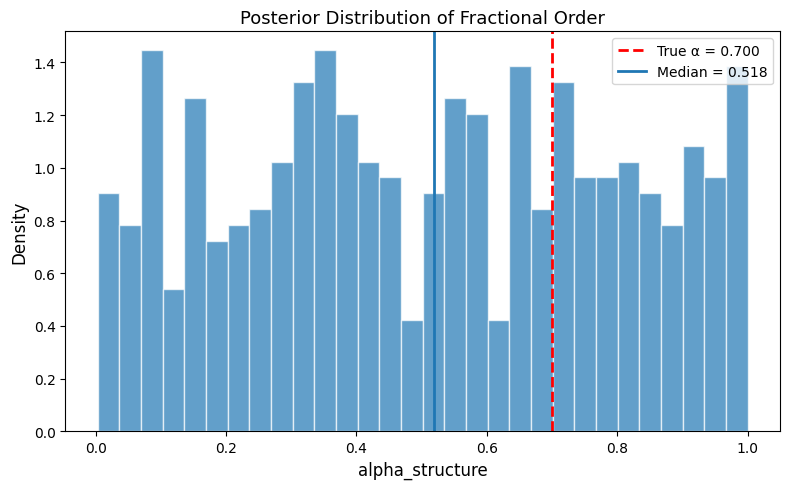

In [13]:
# Alpha posterior histogram
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(alpha_samples, bins=30, density=True, alpha=0.7, color="C0", edgecolor="white")
ax.axvline(true_alpha, color="red", lw=2, linestyle="--", label=f"True α = {true_alpha:.3f}")
ax.axvline(alpha_median, color="C0", lw=2, label=f"Median = {alpha_median:.3f}")
ax.set_xlabel("alpha_structure", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Posterior Distribution of Fractional Order", fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Save Results

In [14]:
save_fikh_results(model_fit, result, "fikh", "relaxation", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/relaxation/


  nlsq_params_relaxation.json: 12 parameters
  posterior_relaxation.json: 500 draws

Results saved.


## Key Takeaways

1. **Stress relaxation reveals power-law memory** most clearly in long-time behavior
2. **Lower alpha** → slower power-law decay $\sigma \sim t^{-\alpha}$
3. **Higher alpha (→1)** → classical exponential decay
4. **Log-log plots essential** for seeing power-law tails
5. **Relaxation data strongly constrains alpha** compared to flow curve data
6. **Synthetic data pipeline** validates parameter recovery

### Next Steps

- **NB04**: Creep (delayed yielding with memory effects)
- **NB05**: SAOS (frequency response)
- **NB06**: LAOS (nonlinear oscillatory)